In [650]:
import pandas as pd
import folium 
import numpy as np
import pandas as pd
from numba.cpython.randomimpl import ol_np_random_beta
from sklearn.model_selection import train_test_split
from sklearn import compose, pipeline, impute
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import  seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [576]:
np.random.seed(42)

In [577]:
df =  pd.read_csv("final.csv")

In [578]:
df

,TYPE,PRICE,BEDS,BATH,PROPERTYSQFT,LOCALITY,SUBLOCALITY,STREET_NAME,LONG_NAME,LATITUDE,...,SUBWAY_STATION,DISTANCE,KINDERGARTEN,SCHOOL,COLLEGE,CAFE,BAR,PARKING,SUPERMARKET,ZIP_CODE
0,Condo,315000.0,2,2,1400.000000,New York,Manhattan,East 55th Street,Regis Residence,40.761255,...,6th Avenue & 56th Street at Southeast Corner,361.441253,6.0,42.0,6.0,353.0,122.0,57.0,54.0,10022
1,Condo,522000.0,7,2,2273.324717,New York,New York County,New York,West 57th Street,40.766393,...,6th Avenue & 57th Street at Southwest Corner,384.829887,3.0,41.0,4.0,327.0,120.0,44.0,46.0,10019
2,Condo,69000.0,3,1,445.000000,New York,New York County,New York,East 55th Street,40.761398,...,6th Avenue & 56th Street at Southeast Corner,342.844227,6.0,41.0,6.0,355.0,122.0,57.0,54.0,10022
3,House,690000.0,5,2,2133.124717,New York,Kings County,Brooklyn,Park Place,40.674363,...,Eastern Parkway - Brooklyn Museum,518.648971,33.0,32.0,1.0,142.0,82.0,5.0,48.0,11238
4,Condo,899500.0,2,2,2184.207862,New York County,New York,Manhattan,157,40.809448,...,Lenox Avenue & 125th Street at Northwest Corner,192.796697,4.0,68.0,2.0,65.0,19.0,2.0,38.0,10027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4131,Co-op,599000.0,1,1,2184.207862,New York County,New York,Manhattan,222,40.774350,...,83rd Street & 2nd Avenue at Northeast Corner,319.462087,3.0,43.0,1.0,154.0,59.0,14.0,42.0,10075
4132,Co-op,245000.0,1,1,2184.207862,New York,Queens County,Queens,62nd Drive,40.732538,...,67th Avenue,840.621152,2.0,6.0,0.0,23.0,4.0,24.0,24.0,11374
4133,Co-op,1275000.0,1,1,2184.207862,New York,New York County,New York,West 21st Street,40.745882,...,Moynihan Train Hall,885.320508,5.0,29.0,6.0,312.0,177.0,21.0,51.0,10011
4134,Condo,598125.0,2,1,655.000000,Queens County,Queens,Flushing,91-23,40.742770,...,Elmhurst Avenue,741.950989,2.0,10.0,0.0,28.0,16.0,9.0,42.0,11373


In [579]:
df["TYPE"].nunique()

8

In [580]:
categorical_preprocessing = compose.make_column_transformer(
    (
        pipeline.make_pipeline(
            TargetEncoder(),
        ),
        compose.make_column_selector(
            dtype_include=object,
        )
    ),
    n_jobs=-1,
    remainder="drop"
)
numerical_preprocessing = compose.make_column_transformer(
    (
        pipeline.make_pipeline(
            impute.SimpleImputer(
                strategy="mean"
            ),
            StandardScaler(
                with_mean=True,
                with_std=True
            )
        ),
        compose.make_column_selector(
            dtype_include=np.number,
        ),    
    ),
    n_jobs=-1,
    remainder="drop"
)

In [581]:
def mse_log(y_true, y_pred):
    y_true_log = np.log1p(y_true)  # логарифмируем истинные значения
    y_pred_log = np.log1p(y_pred)  # логарифмируем предсказания
    mse = np.mean((y_true_log - y_pred_log) ** 2)
    return mse

In [611]:
def metrics_report(y_test,y_pred, model_name= ""):
    mse_log = mean_squared_error(np.log(y_test+1), np.log(y_pred+1))
    rmse = root_mean_squared_error(y_test, y_pred)
    mae  = mean_absolute_error(y_test, y_pred)
    r2= r2_score(y_test, y_pred)
    mape  =  mean_absolute_percentage_error(y_test, y_pred)
    print(f"RMSE {model_name}: {rmse:.2f}")
    print(f"MAPE {model_name}: {mape:.2f}")
    print(f"MAE {model_name}: {mae:.2f}")
    print(f"MSE log target {model_name}: {mse_log:.5f}")
    print(f"R² {model_name}: {r2:.2f}")

In [583]:
transforms = pipeline.make_union(
    categorical_preprocessing
)

In [584]:
df_current_feat = df.columns.drop("PRICE")

In [585]:
X, y = df.drop(["PRICE"], axis=1), df["PRICE"] 

In [586]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

#### Посмотрим на распределение таргетов в обучающей и тестовой выборках

C:\Users\kuzin\AppData\Local\Temp\ipykernel_30200\3380106631.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label = "train")
C:\Users\kuzin\AppData\Local\Temp\ipykernel_30200\3380106631.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, label = "test")


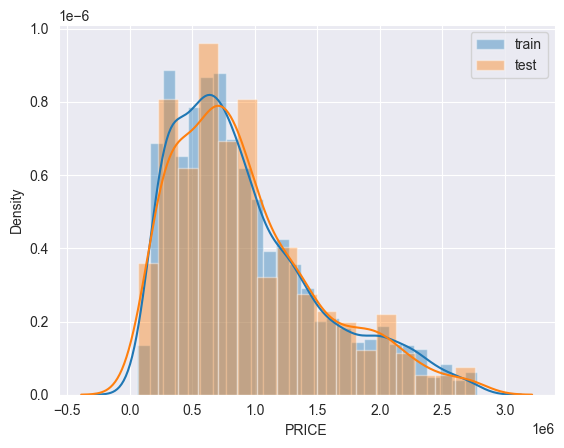

In [587]:
sns.distplot(y_train, label = "train")
sns.distplot(y_test, label = "test")
plt.legend()
plt.show()

#### В тестовой выборке нету значений, сильно больших, чем в обучающей. Так как дальше будем использовать модели на основе решающих деревьев, это важно, так как такие модели не умеют в экстаполяцию 

Применим target энкодер для категориальных признаков на обучающей выборке

In [588]:
encoder = TargetEncoder()
X_train = encoder.fit_transform(X_train, y_train)

In [589]:
def residual_loss(y_true, y_pred):
    """
    Обучение модели на остатках (y_true - y_pred).
    """
    residuals = y_true - y_pred  # Остатки
    grad = -residuals           # Градиент: отрицательные остатки
    hess = np.ones_like(y_true)  # Вторые производные (гессиан) равны 1
    return grad, hess

In [601]:
param_grid = {
    'n_estimators': [50, 100,200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.6, 0.8],
}

Используем xgboost с возможностью дообучения на остатках предущего ансамбля, вместо обучения на градиентах функционала. Также автоматом gain-ом будет MAE в построении деревьев. Нам это важно, так как в датасете могут быть по-прежнему выбросы, а mse будет под них настраиваться сильнее.

In [591]:
def train_xgboost(param_grid, objective = False):
    if objective is not False:
        xgb_model = xgb.XGBRegressor(random_state=42, objective=residual_loss)
    else:
        xgb_model = xgb.XGBRegressor(random_state=42)
    # 3. Параметры для Grid Search
    
    # 4. Grid Search с кросс-валидацией на 5 фолдов
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid, 
        scoring= "neg_mean_absolute_error",  # метрика
        cv=5,  # количество фолдов
        verbose=3,
        n_jobs=-1  # использовать все процессоры
    )
    
    grid_search.fit(X_train, y_train)
    print("Best parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_
    x_for_test = encoder.transform(X=X_test) 
    y_pred = best_model.predict(x_for_test)
    metrics_report(y_test,y_pred, "xgboost")
    
    
    return best_model

xgboost  с дообучением на остатках. Проведём первичный анализ признаков по важности 

In [592]:
model = train_xgboost(param_grid,True)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
RMSE xgboost: 421377.36
MAPE xgboost: 0.37
MAE xgboost: 287350.63
MSE log target xgboost: 0.17850
R² xgboost: 0.48


C:\Users\kuzin\PycharmProjects\MLearning\venv\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


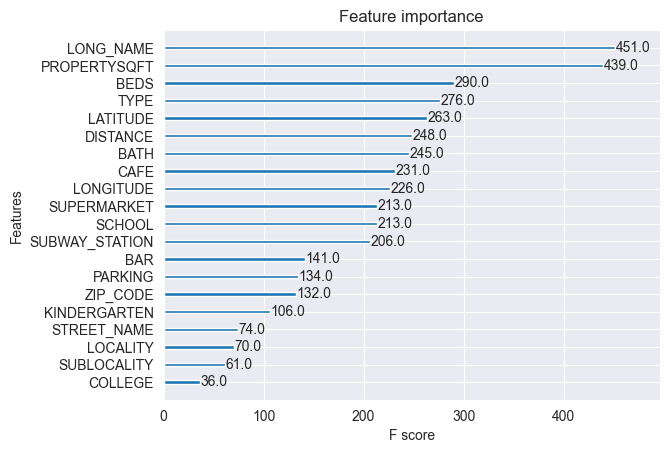

In [593]:
plot_importance(model, importance_type="weight")
plt.show()

In [597]:
to_drop = ['KINDERGARTEN', 'SUBLOCALITY', 'STREET_NAME', 'COLLEGE', "LONG_NAME"]

Видим, что  последние снизу не очень информативны. А также стоит убрать LONG_NAME. Уникальных LONG_NAME у нас почти 2.5 тысячи , это значит что LONG_NAME просто ялвяется более грубой дискретизацией таргет метки, бусту выгодно по ней строить дерево, хотя реальной инофрмативности мало.

In [598]:
X_test = X.drop(to_drop, axis=1)

In [599]:
X_test = X.drop(to_drop, axis=1)
to_drop = ['KINDERGARTEN', 'SUBLOCALITY', 'STREET_NAME', 'COLLEGE', "LONG_NAME"]
X_train, X_test, y_train, y_test = train_test_split(X_test, y, test_size=0.2, shuffle=True)
encoder = TargetEncoder()
X_train = encoder.fit_transform(X_train, y_train)

In [603]:
model = train_xgboost(param_grid,True)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
RMSE xgboost: 330630.90
MAPE xgboost: 0.26
MAE xgboost: 220670.04
MSE log target xgboost: 0.10406
R² xgboost: 0.70


Получили улучшение по MAPE на 11 процентов и по остальным метрикам тоже, продолжаем дальше отбор признаков.

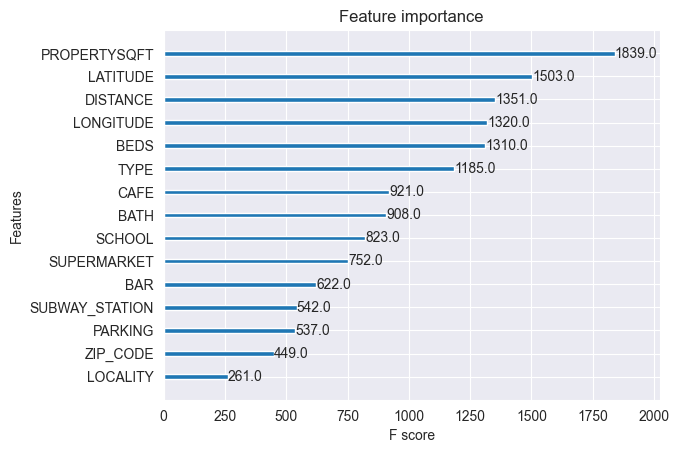

In [604]:
plot_importance(model, importance_type="weight")
plt.show()

Попробуем убрать также "BAR", "LOCALITY"

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
RMSE xgboost: 311015.16
MAPE xgboost: 0.26
MAE xgboost: 201858.20
MSE log target xgboost: 0.09861
R² xgboost: 0.72


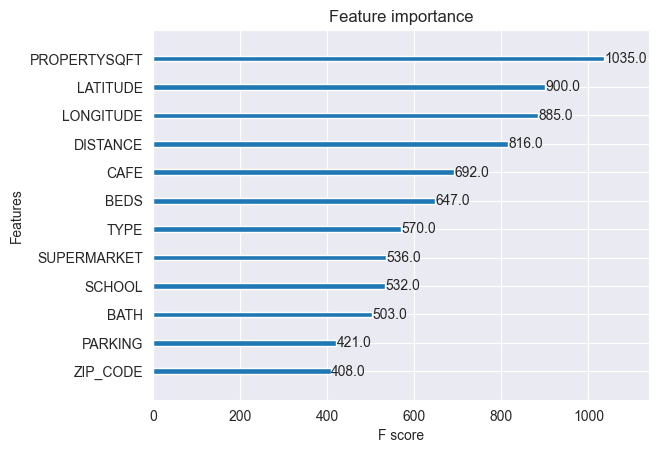

In [613]:
to_drop = ['KINDERGARTEN', 'SUBLOCALITY', 'STREET_NAME', 'COLLEGE', "LONG_NAME", "BAR", "LOCALITY", "SUBWAY_STATION"]
X_test = X.drop(to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_test, y, test_size=0.2, shuffle=True)
encoder = TargetEncoder()
X_train = encoder.fit_transform(X_train, y_train)
model = train_xgboost(param_grid,True)
plot_importance(model, importance_type="weight")
plt.show()

Снова улучшили по MAE и RMSE на 20 тысяч долларов. MAPE по прежнему не меняется, но по всей видимости вносят вклад выбросы. На этом feature selection можно прекратить, в целом уменьшили MAE на 86 тысяч, RMSE на 110, MAPE на 11 процентов. Подведём итог.

В среднем в абсолютном измерении промахиваемся на 200 тысяч долларов в предсказании цены, в относительном смысле промахиваемся на 1/4 судя по MAPE( На том же кэгле у людей  MAE в среднем  2 миллиона, так что резы правда неплохие)

В число наиболее важных признаков входит  DISTANCE - это расстояние до ближайшего метро, этот признак не был в начальном датасете, он был добавлен в результате feature инжинирга и оказался наиболее информативным. Также информативными оказались CAFE, SCHOOL из числа сгенерированных. 
.  

In [635]:
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid, cross_val_score
class TQDMGridSearchCV(GridSearchCV):
    def fit(self, X, y=None, **fit_params):
        self.tqdm_bar = tqdm(total=len(self.cv_results_['params']) if hasattr(self, 'cv_results_') else len(self.param_grid))
        super().fit(X, y, **fit_params)
        self.tqdm_bar.close()
        return self

In [641]:
def train_RF(param_grid, objective = False):
    if objective is not False:
        model = RandomForestRegressor(criterion='absolute_error')
    else:
        model = RandomForestRegressor()
        
    param_combinations = list(ParameterGrid(param_grid))  # Все комбинации параметров
    best_score = -np.inf
    best_params = None
    
    progress_bar = tqdm(param_combinations, desc="Grid Search Progress")
    for params in progress_bar:
        model.set_params(**params)
        scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
        mean_score = np.mean(scores)
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
    
    progress_bar.close()
    
    print("Лучшие параметры:", best_params)
    
    best_model = RandomForestRegressor(**best_params , criterion='absolute_error')
    print("Best parameters:", best_params)
    best_model.fit(X_train, y_train)
    x_for_test = encoder.transform(X=X_test) 
    y_pred = best_model.predict(x_for_test)
    metrics_report(y_test,y_pred, "xgboost")
    
    
    return best_model

In [642]:
param_grid = {
    'n_estimators': [100, 200],  # Количество деревьев
    'max_depth': [5,10, 20],  # Глубина деревьев
    'min_samples_split': [2, 5, 10],  # Минимальное количество выборок для разделения узла
    'min_samples_leaf': [1, 2, 4],  # Минимальное количество выборок в листе
    'max_features': ['sqrt', 'log2'],  # Максимальное количество признаков для разбиения
    'bootstrap': [True],  # Использовать бутстрэпинг
}

In [643]:
model = train_RF(param_grid,True)


Grid Search Progress: 100%|██████████| 108/108 [10:44<00:00,  5.97s/it]


Лучшие параметры: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
RMSE xgboost: 315494.67
MAPE xgboost: 0.27
MAE xgboost: 206679.97
MSE log target xgboost: 0.10662
R² xgboost: 0.71


Попробуем SVM регрессию с rbf ядром, так как из распределения цен на карте уже было видно, что они неплохо кластеризуются 

In [648]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [712]:
param_grid = {
        'C': [20000000],
        'kernel': ['rbf'],
        'gamma': ["auto"] #0.001, 0.01, 0.1, 1, 10, 100, 1000]
        #'degree' : [2,3,4,5]
}

In [713]:
def train_SVR(param_grid, objective = False):
    if objective is not False:
        model = SVR()
    else:
        model = SVR()
        
    param_combinations = list(ParameterGrid(param_grid))  # Все комбинации параметров
    best_score = -np.inf
    best_params = None
    
    progress_bar = tqdm(param_combinations, desc="Grid Search Progress")
    for params in progress_bar:
        model.set_params(**params)
        scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
        mean_score = np.mean(scores)
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
    
    progress_bar.close()
    
    print("Лучшие параметры:", best_params)
    
    best_model = SVR(**best_params)
    print("Best parameters:", best_params)
    best_model.fit(X_train, y_train)
    x_for_test = scaler.transform(encoder.transform(X=X_test))
    y_pred = best_model.predict(x_for_test)
    metrics_report(y_test,y_pred, "xgboost")
    
    
    return best_model

In [714]:
model = train_SVR(param_grid=param_grid,objective=True)


Grid Search Progress: 100%|██████████| 1/1 [00:10<00:00, 10.81s/it]


Лучшие параметры: {'C': 20000000, 'gamma': 'auto', 'kernel': 'rbf'}
Best parameters: {'C': 20000000, 'gamma': 'auto', 'kernel': 'rbf'}
RMSE xgboost: 341837.89
MAPE xgboost: 0.29
MAE xgboost: 227988.14
MSE log target xgboost: 0.13952
R² xgboost: 0.66


Получили результаты, похожие на другие модели, но в целом улучшения не добились. Итог, лучшая модель  XGBoost, параметры и итогвые метрики вверху